In [1]:
import sys
# Change path to point to the root folder 
sys.path.insert(0, "<credit-scoring-root-dir>")

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

from xgboost import XGBClassifier

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import layers

from src.data_preprocessing import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data
data_path = "../data/credit_ds_v3.csv"
df = read_dataset(data_path)

# Train-test split

In [4]:
# Drop null rows before split
df = drop_nulls(df)

In [5]:
# Train test split
X = df.drop('default_flag', axis = 1)
y = df['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

# Feature Engineering

## Transformations

In [6]:
# Functions: process_features, numerical_features_binning
# are located in root/src/

processed_features = FunctionTransformer(process_features)
binned_features = FunctionTransformer(numerical_features_binning)

# Modelling

## Evaluation Metric

The greatest threat to financial sustainability arises when the classifier predicts that a customer will repay their credit and they actually default (FP). Therefore, it is most important to correctly predict the customers who will not repay. For applications that require highly effective detection ability for only one class, it is recommended to consider an alternative metric to accuracy. The credit scoring application is best assessed using the classification metric known as recall. In the case of credit scoring, predicting defaulters is of utmost importance.

In addition, the metric AUROC or AUC-ROC score (Area Under the Receiver Operating Characteristics) is one of the most commonly used measures for evaluating predictive performance.

In this case, the AUROC discriminates customers with a higher credit risk propensity from the good ones. A limitation of the AUROC is that it does not capture the proper performance of models built for datasets with a much larger quantity of negative examples than positive examples.

## Models

### Baseline Model

The baseline model used will be a Linear Regression model that is performed on the original dataset without any enhancements.

In [7]:
# Baseline model on dataset

def baseline(data_path):
    df = read_dataset(data_path)
    df = df.dropna()
    numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
    df = df[numerical_ix]
    X = df.drop('default_flag', axis=1)
    y = df['default_flag']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results = roc_auc_score(y_test, y_pred)
    return results

### Neural Network Model

In [8]:
def neural_network():
    # define the layers
    x_in = Input(shape=(42,))  # This is number of columns after processing
    x1 = layers.Dense(64, activation="relu")(x_in)
    d = layers.Dropout(0.2)(x1)
    x2 = layers.Dense(32, activation="relu")(d)
    x_out = layers.Dense(1, activation="sigmoid")(x2)
    # define the model
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Machine Learning Models

In [9]:
# Models with a class weighting
models_dict = {
    "weighted_random_forest": RandomForestClassifier(n_estimators=30, max_depth=9, class_weight='balanced'),
    "weighted_svm": LinearSVC(C=0.0001, class_weight='balanced'),
    "weighted_xgboostclassifier": XGBClassifier(n_estimators=30, max_depth=9, scale_pos_weight=10),
    "neural_network": KerasClassifier(build_fn=neural_network, verbose=0)
}

## Training

### Baseline

In [10]:
print(f"Baseline AUROC score is: {baseline(data_path)}")

Baseline AUROC score is: 0.738442822384428


### Models

In [11]:
models = models_dict.copy()
for key, classifier in models.items():
    print(f"Model: {key}")
    pipe = make_pipeline(processed_features, binned_features, classifier)
    # fit the pipeline on the transformed data
    pipe.fit(X_train, y_train)   
    # make predictions
    y_pred = pipe.predict(X_test)
    print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification report: \n{classification_report(y_test, y_pred)}")
    print(f"Area under ROC: \n{roc_auc_score(y_test, y_pred)}")
    print("-----------------------------------------------------------")

Model: weighted_random_forest
Confusion matrix: 
[[2020  809]
 [  79  190]]
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2829
           1       0.19      0.71      0.30       269

    accuracy                           0.71      3098
   macro avg       0.58      0.71      0.56      3098
weighted avg       0.90      0.71      0.77      3098

Area under ROC: 
0.7101764649455126
-----------------------------------------------------------
Model: weighted_svm
Confusion matrix: 
[[1811 1018]
 [  60  209]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      2829
           1       0.17      0.78      0.28       269

    accuracy                           0.65      3098
   macro avg       0.57      0.71      0.53      3098
weighted avg       0.90      0.65      0.73      3098

Area under ROC: 
0.708553602426278
-------------------------

The weighted Linear SVM model performs well on recall for the positive class as well as on the AUROC metric. However, it has the lowest accuracy.

In terms of accuracy scores, the ANN performs very well at 91%, followed by XGBoost with 71%.

## Cross Validation

This process will be performed on a Linear SVM model as it has the highest recall and second highest AUROC score.

In [13]:
model = models_dict["weighted_svm"]

pipe = make_pipeline(processed_features, binned_features, model)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Fit and evaluate the pipeline with cross-validation
scores = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# Print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7944
Gini: 0.5889


Using RepeatedStratifiedKFold, the AUROC improved by approximately 9%, thus this model can be used for this task.

## Test Set Evaluation

In [14]:
def transform_df(df):
    df = process_features(df)
    df = numerical_features_binning(df)
    print(f"Shape of dataset: {df.shape}")
    return df

In [39]:
X_test_tr = transform_df(X_test)

y_pred = model.predict(X_test_tr)
print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report: \n{classification_report(y_test, y_pred)}")
print(f"Area under ROC: \n{roc_auc_score(y_test, y_pred)}")

Shape of dataset: (3098, 42)
Confusion matrix: 
[[1811 1018]
 [  60  209]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      2829
           1       0.17      0.78      0.28       269

    accuracy                           0.65      3098
   macro avg       0.57      0.71      0.53      3098
weighted avg       0.90      0.65      0.73      3098

Area under ROC: 
0.708553602426278


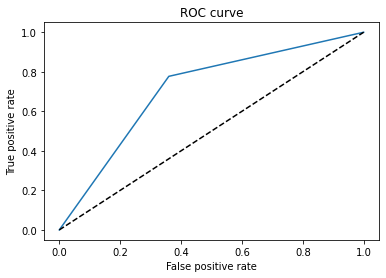

In [40]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the ROC curve
plt.plot(fpr, tpr)

# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

Running the model on the test set returns a 78% recall and 71% AUROC scores which are decent and similar to the evaluation from the training dataset.  

The ROC Curve does look a little suspicious.

# Credit scoring

Here, I will generate a credit score for each customer, and a recommendation on the optimal credit score cutoff point.

### Model Feature Coefficients

In [19]:
# Store the column names in X_train as a list
feature_name = ['outstanding_-1M', 'outstanding_1-2M', 'outstanding_2M-', 'bill_-1M',
       'bill_1-3M', 'bill_3-5M', 'bill_5M-', 'total_retail_usage_-300K',
       'total_retail_usage_300K-2.5M', 'total_retail_usage_2.5M-',
       'overlimit_percentage_2.49', 'overlimit_percentage_2.49M-7.47M',
       'overlimit_percentage_7.47M-17.43M', 'overlimit_percentage_17.43M-',
       'payment_ratio_6month_-37.477', 'payment_ratio_6month_37.477-603.985',
       'payment_ratio_6month_603.985-', 'total_usage_-305K',
       'total_usage_305K-', 'remaining_bill_per_number_of_cards_-1M',
       'remaining_bill_per_number_of_cards_1M-3M',
       'remaining_bill_per_number_of_cards_3M-', 'remaining_bill_per_limit_-1',
       'remaining_bill_per_limit_1-2', 'remaining_bill_per_limit_2-',
       'total_usage_per_limit_-0.0208', 'total_usage_per_limit_0.0208-0.51',
       'total_usage_per_limit_0.51-0.674', 'total_usage_per_limit_0.674-0.837',
       'total_usage_per_limit_0.837-', 'total_3mo_usage_per_limit_-0.0992',
       'total_3mo_usage_per_limit_0.0992-0.55',
       'total_3mo_usage_per_limit_0.55-', 'total_6mo_usage_per_limit_-0.0724',
       'total_6mo_usage_per_limit_0.0724-', 'utilization_3month_-0.588',
       'utilization_3month_0.588-1.176', 'utilization_3month_1.176-2.352',
       'utilization_3month_2.352-', 'utilization_6month_-0.734',
       'utilization_6month_0.734-2.202', 'utilization_6month_2.202-']

# Create a summary table of the model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the model
summary_table['Coefficients'] = np.transpose(model.coef_)

# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1

# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', model.intercept_[0]]

# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.001354
1,outstanding_-1M,0.072725
2,outstanding_1-2M,-0.034422
3,outstanding_2M-,-0.036949
4,bill_-1M,0.011819
5,bill_1-3M,-0.051301
6,bill_3-5M,-0.017608
7,bill_5M-,0.058445
8,total_retail_usage_-300K,0.101545
9,total_retail_usage_300K-2.5M,-0.098794


## Convert model score to points system

Score = (β×WoE+ α/n)×Factor + Offset/n

Where:  
β = model coefficient for characteristics that contains the given attribute  
α = model intercept  
WoE = Weight of Evidence value for the given attribute  
n = number of characteristics included in the model  
Factor = pdo/Ln(2)  
Offset = Score — (Factor × ln(Odds))

For this exercise, I will fit the coefficient within a score threshold.

In [21]:
# Define the min and max threshholds for scorecard
min_score = 300
max_score = 850

In [25]:
df_scorecard = summary_table.copy()
df_scorecard['Original feature name'] = summary_table['Feature name'].str.split('_').str[0]

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()

# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()

# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']

df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,0.001354,Intercept,580.629415,581.0,0.370585,581.0
1,outstanding_-1M,0.072725,outstanding,40.795242,41.0,0.204758,41.0
2,outstanding_1-2M,-0.034422,outstanding,-19.308972,-19.0,0.308972,-19.0
3,outstanding_2M-,-0.036949,outstanding,-20.726795,-21.0,-0.273205,-21.0
4,bill_-1M,0.011819,bill,6.629806,7.0,0.370194,7.0
5,bill_1-3M,-0.051301,bill,-28.777740,-29.0,-0.222260,-29.0
6,bill_3-5M,-0.017608,bill,-9.877459,-10.0,-0.122541,-10.0
7,bill_5M-,0.058445,bill,32.784867,33.0,0.215133,33.0
8,total_retail_usage_-300K,0.101545,total,56.961938,57.0,0.038062,57.0
9,total_retail_usage_300K-2.5M,-0.098794,total,-55.418792,-55.0,0.418792,-55.0


Column "Score - Final" contains the scoring weights of each transformed feature.

In [ ]:
# Specific statistical method for credit scoring or overall risk assessment

## Individual Credit Scores

In [42]:
# X_test_tr_int = pd.DataFrame(X_test_tr.insert(0, 'Intercept', 1))
X_test_tr_int = pd.DataFrame(X_test_tr)

# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(43, 1)

print(X_test_tr_int.shape)
print(scorecard_scores.shape)

# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_tr_int.dot(scorecard_scores)
y_scores.head()

(3098, 43)
(43, 1)


,0
1803,236.0
15204,500.0
12226,159.0
7566,706.0
3575,617.0


Each row is an individual user, and their respective scores are in the column "0". 

## Set Credit Score Cut-off

Calculate overall default rate of portfolio

In [43]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 1.000000


This means that based on the Youden's J statistic, the ideal probability threshold is 1 which minimizes the FPR and maximimizes the TPR - all samples with a predicted probability higher than this should be classified as in Default and vice versa. However, this is not realistically feasible.

## Risk and default levels by deciles

- Create deciles by credit score and provide risk and default levels by deciles (by decile and cumulative)
- Confidence for scores/default rates by bin

# Future Work

- Use SMOTE to balance dataset
- Perform further feature engineering for numerical features:
    - ratios of features
    - log scaling for features with high values 
    - normalization
- Determine feature importances
- Use different models, i.e:
    - Logistic Regression
    - Light Gradient Boosting Machine
- Perform hyper-parameter tuning
- Use an ensemble of models
- Create function to generate scorecard